### This notebook generates the precipitation efficiency distribution for MCSs in the reanalysis-convective tracking data. First import libraries and constants.

In [1]:
import numpy as np
import scipy as sp
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import warnings
import numpy.ma as ma
import seaborn as sns
import scipy.optimize
from scipy.stats import pearsonr, zscore
from scipy.integrate import trapz
from matplotlib import cm
from numpy import unravel_index
from matplotlib.gridspec import GridSpec
from scipy.stats import ks_2samp

plt.rcParams.update({'font.size': 12})

warnings.filterwarnings(action='ignore')

from plotting_utilities import *
from thermodynamic_functions import *

In [2]:
g = 9.8 # gravitational acceleration [m s-2]
rho_air = 1.395 # density of air (kg m-3)
rho_water = 1000 #density of water (kg m-3)
eps = 0.01802/0.02897 # ratio of MW_water to MW_air

## Load ERA data

In [4]:
# array of years
years = np.arange( 2000, 2002 )

# create list of file names
#file_years = file_concatenator_ERAI(years)
file_years = file_concatenator_ERA5(years)

# Are we only looking at tropical MCSs?
minlat_array = nc_open_compile(file_years,"min latitude")
maxlat_array = nc_open_compile(file_years,"max latitude")
omega_array = nc_open_compile(file_years,"w_mean",'stack') # SS 20250204 "omega" -> "w"

tropical_up_indx = np.argwhere( (np.all(omega_array < 0, axis=1)) & (minlat_array >= -10) & (maxlat_array <= 10) )[:,0]
tropical_rain_indx = tropical_up_indx
#tropical_rain_indx = np.argwhere( (minlat_array >= -10) & (maxlat_array <= 10) &
#                                  (pmax_array >= np.percentile(pmax_array,75)) )[:,0]
print(tropical_up_indx.shape)
print(tropical_rain_indx.shape)

# applying same for MCS lifetime and morphology
lifetime_array = nc_open_compile(file_years,"lifetime")
lifetime_ERA = negative_to_nan(lifetime_array)[tropical_rain_indx]
rad_array = nc_open_compile(file_years,"rad")
rad_ERA = negative_to_nan(rad_array)[tropical_rain_indx]
minctt_array = nc_open_compile(file_years,"minctt")
minctt_ERA = negative_to_nan(minctt_array)[tropical_rain_indx]
omega_ERA = positive_to_nan(omega_array)[tropical_rain_indx]

(10206,)
(10206,)


In [5]:
#pressure level values converted into double point precision
#factor of 100 converts hPa to Pa. we want to use SI units exclusively below.
plev_ERA = np.double((xr.open_dataset(file_years[0])).pressure_level.data)*100 # SS 20250204 "pressure" -> "pressure_level
print( plev_ERA )

# calculate the saturation vapor mixing ratio, Curry & Webster (4.37)
# In this calculation, I do not yet filter for tropical lat/lon. That is done below.
temp_ERA = nc_open_compile( file_years, "temperature_mean", 'stack' )[tropical_rain_indx] # SS 20250204 "temperature" -> "temeprature_mean"
qvsat_ERA = eps * satVapP_liq(temp_ERA) / ( plev_ERA - satVapP_liq(temp_ERA) )

[100000.  97500.  95000.  92500.  90000.  87500.  85000.  82500.  80000.
  77500.  75000.  70000.  65000.  60000.  55000.  50000.  45000.  40000.
  35000.  30000.  25000.  22500.  20000.  17500.  15000.  12500.]


In [6]:
# as in Singh et al. 2017 we calculate saturation deficit as the arithmetic mean
# between its values at 850, 700, and 550 hPa
qv_array = nc_open_compile( file_years, "qv_mean", 'stack' ) # SS 20250204 "qv" -> "qv_mean"
qv_ERA = negative_to_nan(qv_array)[tropical_rain_indx]
#qvpre_array = nc_open_compile( file_years, "qvpre", 'stack' )
#qvpre_ERA = negative_to_nan(qvpre_array)[tropical_rain_indx]

i = np.argmin( np.abs(plev_ERA - 85000) )
sd850_ERA = (qvsat_ERA[:,i] - qv_ERA[:,i])*1000   # 1000 converts [kg kg-1] to [g kg-1]
#sd850pre_ERA = (qvsat_ERA[:,i] - qvpre_ERA[:,i])*1000
i = np.argmin( np.abs(plev_ERA - 70000) )
sd700_ERA = (qvsat_ERA[:,i] - qv_ERA[:,i])*1000
#sd700pre_ERA = (qvsat_ERA[:,i] - qvpre_ERA[:,i])*100
i = np.argmin( np.abs(plev_ERA - 55000) )
sd550_ERA = (qvsat_ERA[:,i] - qv_ERA[:,i])*1000
#sd550pre_ERA = (qvsat_ERA[:,i] - qvpre_ERA[:,i])*1000

sd_ERA = (sd850_ERA + sd700_ERA + sd550_ERA)/3
#sdpre_ERA = (sd850pre_ERA + sd700pre_ERA + sd550pre_ERA)/3

### Precipitation efficiency from integrated condensation rate scaling

## Filter by MCS morphology

### Calculate LWP and IWP

In [35]:
# Integrated amounts of cloud condensate - how strong is correlation with these?
# Do not filter for tropical lat/lon yet. That is done below.
qi_array = nc_open_compile(file_years,"qi_mean","stack") # SS 20250204 "qi" -> "qi_mean"
qi_ERA = negative_to_nan(qi_array)[tropical_rain_indx]

# This method of evaluating IWP omits instances in which there is a NaN sandwiched between numeric values.
# But these instances only constitute 3% of all samples.
IWP_ERA = np.zeros( (qi_ERA.shape[0],) )
for i in np.arange(qi_ERA.shape[0]):
    j = np.argwhere( ~np.isnan(qi_ERA[i]) )
    if len( j ) > 0:
        start = j[0][0]
        end = j[-1][0]
        IWP_ERA[i] = np.trapz( qi_ERA[i,start:end] / g, np.flip(plev_ERA[start:end]) )*1000 # [g m-2] # SS 20250204 flip plev
    else:
        continue

In [36]:
qc_array = nc_open_compile(file_years,"qc_mean","stack") # SS 20250204 "qc" -> "qc_mean"
qc_ERA = negative_to_nan(qc_array)[tropical_rain_indx]

# This method of evaluating LWP omits instances in which there is a NaN sandwiched between numeric values.
# But these instances only constitute 3% of all samples.
LWP_ERA = np.zeros( (qc_ERA.shape[0],) )
for i in np.arange(qc_ERA.shape[0]):
    j = np.argwhere( ~np.isnan(qc_ERA[i]) )
    if len( j ) > 0:
        start = j[0][0]
        end = j[-1][0]
        LWP_ERA[i] = np.trapz( qc_ERA[i,start:end] / g, np.flip(plev_ERA[start:end]) )*1000 # [g m-2] # SS 20250204 flip plev
    else:
        continue

In [47]:
upp = np.percentile( rad_ERA, 75 )
loo = np.percentile( rad_ERA, 25 )
condensate_ERA = np.nansum( (qc_ERA, qi_ERA), axis=0  )
condensate_small = np.nansum( (qc_ERA[rad_ERA <= loo], qi_ERA[rad_ERA <= loo]), axis=0 )
condensate_large = np.nansum( (qc_ERA[rad_ERA >= upp], qi_ERA[rad_ERA >= upp]), axis=0 )

CWP_ERA = LWP_ERA + IWP_ERA
CWP_small = LWP_ERA[rad_ERA <= loo] + IWP_ERA[rad_ERA <= loo]
CWP_large = LWP_ERA[rad_ERA >= upp] + IWP_ERA[rad_ERA >= upp]
print(np.nanmean(CWP_ERA),np.nanmean(CWP_small),np.nanmean(CWP_large))
print( (np.nanmean(CWP_small)-np.nanmean(CWP_large))/np.nanmean(CWP_large) )
print( (np.nanpercentile(CWP_small,99)-np.nanpercentile(CWP_large,99))/np.nanpercentile(CWP_large,99) )
print( (np.nanmean(LWP_ERA[rad_ERA <= loo])-np.nanmean(LWP_ERA[rad_ERA >= upp]))/np.nanmean(LWP_ERA[rad_ERA >= upp]) )
print( (np.nanmean(IWP_ERA[rad_ERA <= loo])-np.nanmean(IWP_ERA[rad_ERA >= upp]))/np.nanmean(IWP_ERA[rad_ERA >= upp]) )

235.77237046432458 262.9653868488685 210.13678274256722
0.2514010323029459
0.42924768554912845
0.2809021869417816
0.23041853877684781


In [44]:
# Are the CWP distributions statistically significant for small versus large MCSs?
upp = np.percentile( rad_ERA, 75 )
loo = np.percentile( rad_ERA, 25 )
data1 = CWP_ERA
data2 = CWP_ERA[rad_ERA >= upp]
data3 = CWP_ERA[rad_ERA <= loo]

statistic, p_value = ks_2samp( data1, data2 )
print( statistic, p_value )
statistic, p_value = ks_2samp( data2, data3 )
print( statistic, p_value )
statistic, p_value = ks_2samp( data1, data3 )
print( statistic, p_value )

0.11463606940563931 7.618204041391945e-24
0.20768145439630534 2.0483962097196062e-50
0.10077158164345568 1.6357097599014977e-19


In [45]:
for i in np.arange( plev_ERA.shape[0] ):
    print( (np.nanpercentile(condensate_large,99,axis=1)[i]-np.nanpercentile(condensate_small,99,axis=1)[i])/np.nanpercentile(condensate_small,99,axis=1)[i] )
    print( plev_ERA[i] )
    print( '~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~' )

0.16539786091400388
100000.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-0.16872216276882587
97500.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-0.08529384372828051
95000.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
1.1618471140765931
92500.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-0.1846873300137534
90000.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.5968245370402363
87500.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-0.5219753269323473
85000.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-0.15372236370029518
82500.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-0.2365756978761174
80000.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-0.2567056707231624
77500.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
0.22411109731141698
75000.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-0.5423899325435736
70000.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-0.3624771129196019
65000.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-0.13734901378236614
60000.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-0.23101462936408734
55000.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-0.5912552339218898
50000.0
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
-0.7012655346916303
45000.0
~~~~~~~~~~~~~~~~~~~~~~~~

## Plot distributions of precipitation efficiency, CWP, and cloud condensate

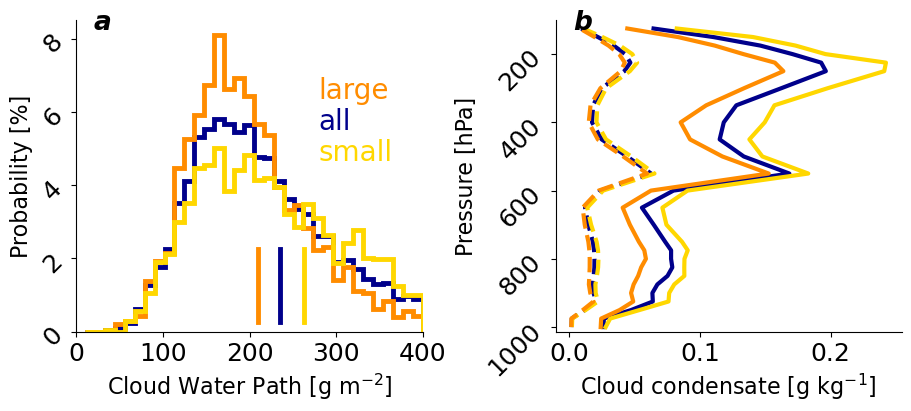

In [48]:
fig, ax = plt.subplots( 1, 2, figsize =(9, 4), constrained_layout=True )
lw = 3.5
fs = 16
upper = 400
xlab = [ r'Cloud Water Path [g m$^{-2}$]', r'Cloud condensate [g kg$^{-1}$]' ]

wgts = np.ones_like( CWP_ERA )/float( len( CWP_ERA) )*100
edges, h = np.histogram( CWP_ERA, weights=wgts, bins=np.linspace(10,upper,35) )
wgts2 = np.ones_like( CWP_large )/float( len(CWP_large) )*100
edges2, h2 = np.histogram( CWP_large, weights=wgts2, bins=np.linspace(10,upper,35) )
wgts3 = np.ones_like( CWP_small )/float( len(CWP_small) )*100
edges3, h3 = np.histogram( CWP_small, weights=wgts3, bins=np.linspace(10,upper,35) )

ax[0].stairs( edges, h, edgecolor='darkblue', lw=lw )
ax[0].stairs( edges2, h2, edgecolor='darkorange', lw=lw )
ax[0].stairs( edges3, h3, edgecolor='gold', lw=lw )
ax[0].plot( [np.nanmean(CWP_ERA), np.nanmean(CWP_ERA)], [0.25,2.25], color='darkblue', lw=lw )
ax[0].plot( [np.nanmean(CWP_large), np.nanmean(CWP_large)], [0.25,2.25], color='darkorange', lw=lw )
ax[0].plot( [np.nanmean(CWP_small), np.nanmean(CWP_small)], [0.25,2.25], color='gold', lw=lw )
ax[0].set_ylabel( 'Probability [%]', fontsize=fs )
ax[0].text( 0.05, 0.97, 'a', weight='bold', style='italic', fontsize=fs+3, transform=ax[0].transAxes )
ax[0].text( 0.7, 0.75, 'large', color='darkorange', fontsize=fs+4, transform=ax[0].transAxes )
ax[0].text( 0.7, 0.65, 'all', color='darkblue', fontsize=fs+4, transform=ax[0].transAxes )
ax[0].text( 0.7, 0.55, 'small', color='gold', fontsize=fs+4, transform=ax[0].transAxes )
ax[0].set_xlim( [0,400] )

ax[1].set_ylim( [1013,100] )
ax[1].plot( (np.nanmean(condensate_ERA,axis=0) )*1000, plev_ERA/100., color='darkblue', lw=3, ls='--' )
ax[1].plot( (np.nanmean(condensate_small,axis=0) )*1000, plev_ERA/100., color='gold', lw=3, ls='--' )
ax[1].plot( (np.nanmean(condensate_large,axis=0) )*1000, plev_ERA/100., color='darkorange', lw=3, ls='--' )
ax[1].plot( (np.nanpercentile(condensate_ERA,99,axis=0) )*1000, plev_ERA/100., color='darkblue', lw=3 )
ax[1].plot( (np.nanpercentile(condensate_small,99,axis=0) )*1000, plev_ERA/100., color='gold', lw=3 )
ax[1].plot( (np.nanpercentile(condensate_large,99,axis=0) )*1000, plev_ERA/100., color='darkorange', lw=3 )
ax[1].text( 0.05, 0.97, 'b', weight='bold', style='italic', fontsize=fs+3, transform=ax[1].transAxes )
#ax[1].set_xscale( 'log' )
ax[1].set_ylabel( 'Pressure [hPa]', fontsize=fs )

for i, a in enumerate(ax):
    a.set_xlabel( xlab[i], fontsize=fs )
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.tick_params( 'both', labelsize=18 )
    a.tick_params( 'y', rotation=45 )

#fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/condensate-ERA.pdf', bbox_inches='tight' )
plt.show()

### filtering precipitation efficiency for different morphological parameters and intensities

In [ ]:
omega_array = nc_open_compile(file_years,"w_mean",'stack').values
pmax_array = nc_open_compile(file_years,"pmax").values
indx1 = np.argwhere( (pmax_array >= np.percentile(pmax_array,75)) & (np.all(omega_array < 0, axis=1)) &
                                (minlat_array >= -10) & (maxlat_array <= 10) )[:,0]
indx2 = np.argwhere( (pmax_array >= np.percentile(pmax_array,90)) & (np.all(omega_array < 0, axis=1)) &
                                (minlat_array >= -10) & (maxlat_array <= 10) )[:,0]
peff_other = [[] for i in np.arange(2)]
for j, i in enumerate([indx1, indx2]):
    T = nc_open_compile( file_years, "temperature_mean", 'stack' )[i]
    qvsat = eps * satVapP_liq(T) / ( plev_ERA - satVapP_liq(T) )
    dqvsat_dp = np.gradient( qvsat, p_ERA, axis=1 )
    omega = nc_open_compile(file_years,"omega_mean",'stack')[i]
    integrand = 100*omega * dqvsat_dp / g
    Tmean = np.nanmean( T, axis=0 )
    cond_rate = np.trapz( x=p_ERA[:-1], y=-1.*integrand[:,:-1] )
    pmax = pmax_array[i]
    peff_other[j].extend( pmax / 3600 / cond_rate )

NameError: name 'peff_other' is not defined

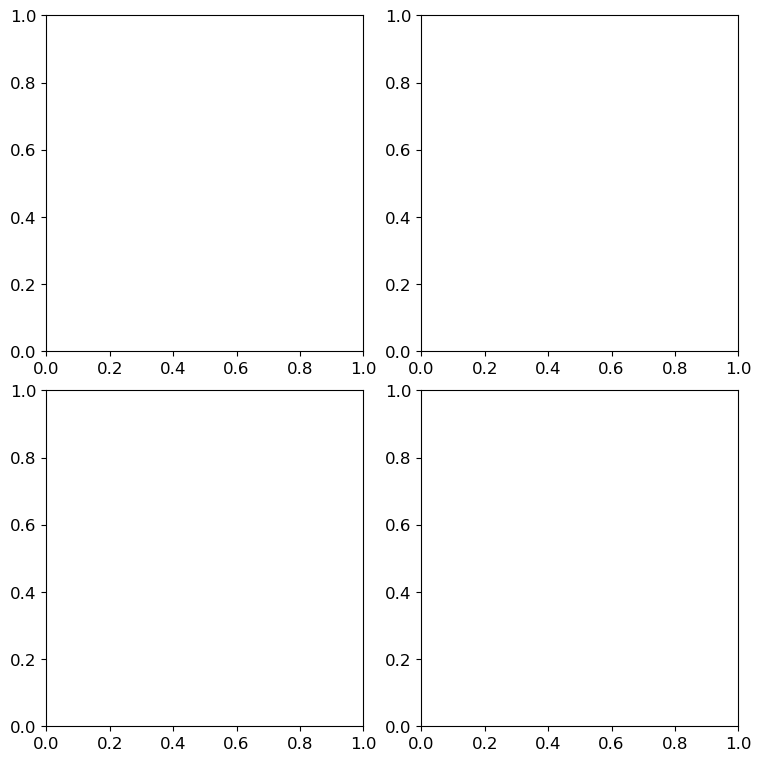

In [41]:
fig, ax = plt.subplots( nrows=2, ncols=2, figsize =(7.5, 7.5), constrained_layout=True )

wgts = np.ones_like( peff_other[0] )/float( len( peff_other[0] ) )*100
edges, h = np.histogram( np.array(peff_other[0]), weights=wgts, bins=np.logspace(-3.5,0,35) )
ax[0,0].stairs( edges, h, edgecolor='darkblue', lw=lw )
ax[0,0].text( 0.05, 0.85, r"$<\varepsilon_p>$=" + f"{np.nanmean(peff_other[0]):.3}", color='darkblue', fontsize=fs+3, transform=ax[0,0].transAxes)
ax[0,0].text( 0.05, 0.7, r"$\dot{P}_{75}$", color='darkblue', fontsize=fs+3, transform=ax[0,0].transAxes )
ax[0,0].set_ylim( [0,18])
ax[0,0].set_ylabel( 'Probability [%]', fontsize=fs )
ax[0,0].text( 0.05, 0.95, 'a', weight='bold', fontsize=fs+4, style='italic', transform=ax[0,0].transAxes )

wgts = np.ones_like( peff_other[1] )/float( len( peff_other[1] ) )*100
print(wgts)
edges, h = np.histogram( np.array(peff_other[1]), weights=wgts, bins=np.logspace(-3.5,0,35) )
ax[0,1].stairs( edges, h, edgecolor='darkblue', lw=lw )
ax[0,1].set_ylim( [0,18])
ax[0,1].text( 0.05, 0.95, 'b', weight='bold', fontsize=fs+4, style='italic', transform=ax[0,1].transAxes )
ax[0,1].text( 0.05, 0.85, r"$<\varepsilon_p>$=" + f"{np.nanmean(peff_other[1]):.3}", color='darkblue', fontsize=fs+3, transform=ax[0,1].transAxes)
ax[0,1].text( 0.05, 0.7, r"$\dot{P}_{90}$", color='darkblue', fontsize=fs+3, transform=ax[0,1].transAxes )

wgts = np.ones_like( peff_ERA )/float( len( peff_ERA ) )*100
edges, h = np.histogram( peff_ERA, weights=wgts, bins=np.logspace(-3.5,0,35) )
loo = np.percentile( lifetime_ERA, 25 )
upp = np.percentile( lifetime_ERA, 75 )
wgts6 = np.ones_like( peff_ERA[lifetime_ERA >= upp] )/float( len( peff_ERA[lifetime_ERA >= upp] ) )*100
edges6, h6 = np.histogram( peff_ERA[lifetime_ERA >= upp], weights=wgts6, bins=np.logspace(-3.5,0,35) )
wgts7 = np.ones_like( peff_ERA[lifetime_ERA <= loo] )/float( len( peff_ERA[lifetime_ERA <= loo] ) )*100
edges7, h7 = np.histogram( peff_ERA[lifetime_ERA <= loo], weights=wgts7, bins=np.logspace(-3.5,0,35) )

ax[1,0].stairs( edges, h, edgecolor='darkblue', lw=lw )
ax[1,0].stairs( edges6, h6, edgecolor='pink', lw=lw )
ax[1,0].stairs( edges7, h7, edgecolor='darkred', lw=lw )
ax[1,0].plot( [np.nanmean(peff_ERA), np.nanmean(peff_ERA)], [2.5,5], color='darkblue', lw=lw )
ax[1,0].plot( [np.nanmean(peff_ERA[lifetime_ERA>=upp]), np.nanmean(peff_ERA[lifetime_ERA>=upp])], [2.5,5], color='pink', lw=lw )
ax[1,0].plot( [np.nanmean(peff_ERA[lifetime_ERA<=loo]), np.nanmean(peff_ERA[lifetime_ERA<=loo])], [2.5,5], color='darkred', lw=lw )
ax[1,0].text( 0.02, 0.85, r"$<\varepsilon_p>$=" + f"{np.nanmean(peff_ERA):.3}", color='darkblue', fontsize=fs, transform=ax[1,0].transAxes)
ax[1,0].text( 0.02, 0.75, r"$<\varepsilon_p>$=" + f"{np.nanmean(peff_ERA[lifetime_ERA<=loo]):.3}", color='darkred', fontsize=fs, transform=ax[1,0].transAxes)
ax[1,0].text( 0.02, 0.65, r"$<\varepsilon_p>$=" + f"{np.nanmean(peff_ERA[rad_ERA>=upp]):.3}", color='pink', fontsize=fs, transform=ax[1,0].transAxes)
ax[1,0].text( 0.05, 0.95, 'c', weight='bold', fontsize=fs+4, style='italic', transform=ax[1,0].transAxes )
ax[1,0].set_ylabel( 'Probability [%]', fontsize=fs )
ax[1,0].set_xlabel( r'Precipitation efficiency $\varepsilon_p$ [-]', fontsize=fs )

loo = np.percentile( minctt_ERA, 25 )
upp = np.percentile( minctt_ERA, 75 )
wgts4 = np.ones_like( peff_ERA[minctt_ERA >= upp] )/float( len( peff_ERA[minctt_ERA >= upp] ) )*100
edges4, h4 = np.histogram( peff_ERA[minctt_ERA >= upp], weights=wgts4, bins=np.logspace(-3.5,0,35) )
wgts5 = np.ones_like( peff_ERA[minctt_ERA <= loo] )/float( len( peff_ERA[minctt_ERA <= loo] ) )*100
edges5, h5 = np.histogram( peff_ERA[minctt_ERA <= loo], weights=wgts5, bins=np.logspace(-3.5,0,35) )

ax[1,1].stairs( edges, h, edgecolor='darkblue', lw=lw )
ax[1,1].stairs( edges4, h4, edgecolor='green', lw=lw )
ax[1,1].stairs( edges5, h5, edgecolor='turquoise', lw=lw )
ax[1,1].plot( [np.nanmean(peff_ERA), np.nanmean(peff_ERA)], [2.5,5], color='darkblue', lw=lw )
ax[1,1].plot( [np.nanmean(peff_ERA[minctt_ERA<=loo]), np.nanmean(peff_ERA[minctt_ERA<=loo])], [2.5,5], color='turquoise', lw=lw )
ax[1,1].plot( [np.nanmean(peff_ERA[minctt_ERA>=upp]), np.nanmean(peff_ERA[minctt_ERA>=upp])], [2.5,5], color='green', lw=lw )
ax[1,1].text( 0.02, 0.75, r"$<\varepsilon_p>$=" + f"{np.nanmean(peff_ERA[minctt_ERA<=loo]):.3}", color='turquoise', fontsize=fs, transform=ax[1,1].transAxes)
ax[1,1].text( 0.02, 0.65, r"$<\varepsilon_p>$=" + f"{np.nanmean(peff_ERA[minctt_ERA>=upp]):.3}", color='green', fontsize=fs, transform=ax[1,1].transAxes)
ax[1,1].text( 0.05, 0.95, 'd', weight='bold', fontsize=fs+4, style='italic', transform=ax[1,1].transAxes )
ax[1,1].set_xlabel( r'Precipitation efficiency $\varepsilon_p$ [-]', fontsize=fs )

for a in ax.flatten():
    a.set_xscale( 'log' )
    a.tick_params( 'both', labelsize=fs )
    a.tick_params( 'y', rotation=45 )
    a.spines['top'].set_visible(False)
    a.spines['right'].set_visible(False)
    a.set_xlim([10**(-3.5),1])

fig.savefig( '/groups/sylvia/JAS-MCS-rain/figures/S6-precipeff-others.pdf', bbox_inches='tight' )
plt.show()

## Calculate correlations of precipitation efficiency with different conditions

In [14]:
# Thermodynamic parameters - how strong is correlation with these?
# Do not filter for tropical lat/lon yet. That is done below.
t2m_array = nc_open_compile(file_years,"t2m")
t2m_ERA = negative_to_nan(t2m_array)[tropical_up_indx]
dpt_array = nc_open_compile(file_years,"dpt")
dpt_ERA = negative_to_nan(dpt_array)[tropical_up_indx]
sst_array = nc_open_compile(file_years,"sst")
sst_ERA = negative_to_nan(sst_array)[tropical_up_indx]

In [15]:
# CAPE and integrated mass flux - how strong is correlation with these?
cape_array = nc_open_compile(file_years,"cape")
cape_ERA = negative_to_nan(cape_array)[tropical_up_indx]
capepre_array = nc_open_compile(file_years,"capepre")
capepre_ERA = negative_to_nan(capepre_array)[tropical_up_indx]
capepre6_array = nc_open_compile(file_years,"capepre6")
capepre6_ERA = negative_to_nan(capepre6_array)[tropical_up_indx]
omega_array = nc_open_compile(file_years,"omega","stack")
omega_ERA = positive_to_nan(omega_array)[tropical_up_indx]
#omegaint_ERA = np.cumsum( rho*w_ERA, axis=1 )*1000 # [g m-2]
#print(omegaint_ERA.shape)
#omegaint_ERA = omegaint_ERA[:,-1]
#print(omegaint_ERA.shape)

In [120]:
print('Correlation of precip efficiency with storm morphology parameters')
for var in [ rad_ERA, maxrad_ERA, ctt_ERA, minctt_ERA, lifetime_ERA ]:
    print( pe_cc( var, peff_ERA) )

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with LWP versus IWP')
for var in [ LWP_ERA, IWP_ERA ]:
    print( pe_cc( var, peff_ERA) )
    
print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with various surface temperatures')
for var in [ t2m_ERA, sst_ERA, dpt_ERA ]:
    print( pe_cc( var, peff_ERA) )

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with CAPE')
for var in [ cape_ERA, capepre_ERA, capepre6_ERA ]:
    print( pe_cc( np.sqrt(var), peff_ERA) )

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with SD')
for var in [ sd_ERA, sdpre_ERA ]:
    print( pe_cc( var, peff_ERA) )

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with qc/qi at different levels')
for j in np.arange( 10, 32 ):
    print( plev_ERA[j], pe_cc( qc_ERA[:,j], peff_ERA ) )

print('~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~')
print('Correlation of precip efficiency with omega at different levels')
for j in np.arange( 10, 32 ):
    print( plev_ERA[j], pe_cc( -1.*omega_ERA[:,j], peff_ERA ) )


Correlation of precip efficiency with storm morphology parameters
(0.14375467306347212, 2.360158939359827e-128)
(0.0651042685157914, 3.530743736696998e-27)
(0.0574094156690236, 1.3439981637056307e-22)
(-0.0336623976425557, 1.2822349005831719e-08)
(0.03936595657852139, 4.078378120417973e-11)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip efficiency with LWP versus IWP
(0.043030777804594515, 3.467525023297834e-13)
(0.02472226615206962, 2.624388599517965e-05)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip efficiency with various surface temperatures
(-0.025177558345937743, 1.8595280400510198e-05)
(0.012481061625921122, 0.07019295558502237)
(0.04404085883147206, 6.270793233765703e-14)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip efficiency with CAPE
(0.01636898226480419, 0.011622303716186463)
(0.009608324567587676, 0.15499328994228562)
(-0.002585880409806865, 0.6939559064354525)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Correlation of precip